In [1]:
import pandas as pd
import sys
sys.path.append('..')  # Adjust the path based on your project structure
import json
import re
import ast
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, RocCurveDisplay,  average_precision_score
import matplotlib.pyplot as plt
import os.path as osp
from glob import glob
# from miga.const import ID2LABELS_SMG_SHORT as ID2LABELS
from mac2024.const import ID2LABELS as ID2LABELS
from mac2024.const import fine2coarse, COARSE_LABEL, COARSE2FINE

import datetime

In [2]:
COARSE2FINE


{0: range(0, 5),
 1: range(5, 11),
 2: range(11, 24),
 3: range(24, 32),
 4: range(32, 38),
 5: range(38, 46),
 6: range(48, 52)}

In [3]:
from pathlib import Path
def load_and_parse_txt(path_or_list, feature_names, file_names):
    # Read the text file into a list of lines
    if isinstance(path_or_list, list):
        
        df_list = []
        logit_columns_list = []
        pred_columns_list = []
        gt_columns_list = []
        for p in path_or_list:
            df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(p, feature_names, file_names)
            df_list.append(df)
            logit_columns_list.append(logit_columns)
            pred_columns_list.append(pred_columns)
            gt_columns_list.append(gt_columns)
        return pd.concat(df_list), logit_columns_list, pred_columns_list, gt_columns_list
    elif isinstance(path_or_list, str):
        path = path_or_list

    with open(path, 'r') as file:
        lines = file.readlines()
    


    # Extract relevant information from each line
    data = []
    indecies = []
    TH = 0.4
    for line in lines[1:]:

        
        # Use regex to find index, predictions, and targets
        # match = re.match(r'(\d+)\s+\[([^\]]+)\]\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)', line.strip())
        # match = re.match(r'(\d+\-[^ ]+)\s+\[([^\]]+)\]\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)', line.strip())
        match = re.match(r'(.*?)\s+\[([^\]]+)\]\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)', line.strip())
        if match:
    

            # index = int(match.group(1))
            index = match.group(1)
            
            # Extract model predictions and convert to list using ast
            logits_str = match.group(2)
            logits = list(ast.literal_eval(logits_str))
            
            predictions = ((np.array(logits)>TH).astype(int)).tolist()


            # Extract targets and convert to list using ast
            targets_str = f'[{match.group(3)}]'
            targets = list(np.array(ast.literal_eval(targets_str)))

            
            row_data = logits + predictions + targets 
            row_data = np.array(row_data)
            data.append(row_data)
            # indecies.append(int(index))
            indecies.append(index)

    # Create column names
    logit_columns = [f"logit-{name}" for name in feature_names]
    pred_columns = [f"pred-{name}" for name in feature_names]
    gt_columns = [f"gt-{name}" for name in feature_names]
    columns = logit_columns + pred_columns + gt_columns 

    # Create Pandas DataFrame
    df = pd.DataFrame(data, columns=columns, index=indecies)
    df[pred_columns+gt_columns] = df[pred_columns+gt_columns].astype(int)
    # print(df.iloc[0])
    # print(df.tail(1))
    df['filenames'] = file_names
    df['log_name'] = osp.basename(path)

    return df, logit_columns, pred_columns, gt_columns
    # return data, columns
# df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(path_to_log, feature_names,file_names)

In [4]:
# experiment_folder = '/home/ubuntu/efs/videoMAE/scripts/MPIIGroupInteraction'
# experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\scripts\miga_smg'
# run_name = 'videomae_vit_base_patch16_224_kinetic_400_densepose_dual_multi'

# experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments\resampled_64_multi_update_freq_8'
# run_name = 'eval_on_original'
# 'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments\resampled_64_multi_update_freq_8\eval after downsampleing'
experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments'
run_name = 'mac_multi'

In [5]:
# path_to_weights = '/home/ubuntu/efs/videoMAE/scripts/dyadic_communication_001/dataset/weights.json'
# experiment_folder = '/home/ubuntu/efs/videoMAE/scripts/dyadic_communication_5vid_clean'
# run_name = 'videomae_vit_base_patch16_224_tubemasking_ratio_0.9_kinetic_400'
path_to_weights = osp.join(experiment_folder,run_name,'dataset','weights.json')
with open(path_to_weights, 'r') as json_file:
    positive_weights_dict = json.load(json_file)

        
feature_names = [entry['class'] for entry in positive_weights_dict['data']]

In [6]:
# path_to_log = glob(osp.join(experiment_folder,run_name,'outputs_eval','*.txt'))
# # path_to_dataset = osp.join(experiment_folder,run_name,'dataset','test.csv')
# path_to_dataset = osp.join(experiment_folder,run_name,'dataset','val.csv')

# path_to_log = glob(osp.join(experiment_folder,run_name,'','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'eval','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'eval after downsampleing','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'validation_best_after_100_epochs','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'delete_later','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'eval_28','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'eval_93','*.txt'))
path_to_log = glob(osp.join(experiment_folder,run_name,'split_loss_fine_coarse','eval_49','*.txt'))


# path_to_dataset = osp.join(experiment_folder,run_name,'dataset','test.csv')
path_to_dataset = osp.join(experiment_folder,run_name,'dataset','val.csv')



# Get names of file names from the csv file
df_csv = pd.read_csv(path_to_dataset)
file_names = df_csv['filenames'].tolist()
metadata = df_csv['metadata'].tolist()
df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(path_to_log, feature_names,file_names)
# df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(path_to_log, feature_names,'')
# data, columns = load_and_parse_txt(path_to_log, feature_names)
df = df.drop(columns='log_name').groupby('filenames').mean()
logit_columns=logit_columns[0]
pred_columns=pred_columns[0]
gt_columns=gt_columns[0]

C:\Users\user\AppData\Local\Temp\ipykernel_5084\802085671.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['filenames'] = file_names
C:\Users\user\AppData\Local\Temp\ipykernel_5084\802085671.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['log_name'] = osp.basename(path)


In [7]:
df

,logit-shaking body,logit-sitting straightly,logit-shrugging,logit-turning around,logit-rising up,logit-bowing head,logit-head up,logit-tilting head,logit-turning head,logit-nodding,...,gt-covering mouth,gt-pushing glasses,gt-patting legs,gt-touching legs,gt-scratching legs,gt-scratching feet,gt-body,gt-head,gt-hands,gt-legs
filenames,,,,,,,,,,,,,,,,,,,,,
0003_01_0005.mp4,-4.015625,-8.070312,-6.902344,-7.679688,-6.621094,-3.558594,-2.982422,1.491211,2.187500,-1.694336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0003_01_0006.mp4,-5.054688,-7.488281,-7.230469,-8.562500,-6.023438,-2.306641,-3.458984,-1.198242,-0.294922,2.105469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0003_01_0008.mp4,-3.035156,-4.828125,-4.558594,-7.417969,-4.933594,-2.669922,-2.386719,0.517578,-0.778809,3.091797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0003_01_0015.mp4,-3.111328,-6.390625,-4.621094,-7.175781,-4.500000,-2.708984,-2.537109,0.181152,0.667480,-1.687500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0003_01_0021.mp4,-6.023438,-6.382812,-8.273438,-10.164062,-6.253906,-2.179688,-1.978516,-3.335938,-4.480469,4.742188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0193_05_0006.mp4,-4.617188,-3.537109,-5.886719,-7.023438,-4.550781,0.067932,-0.732422,0.126343,-1.546875,-1.998047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
0193_05_0011.mp4,-5.488281,-4.027344,-3.923828,-7.015625,-5.988281,-0.473145,-0.872559,-0.334961,0.416504,-0.872559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
0193_05_0013.mp4,-4.722656,-4.972656,-6.859375,-4.105469,-4.683594,0.330078,-3.894531,0.247070,-1.734375,-2.875000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [22]:
# remove coarse labels

# body_parts = ['hands','head','legs','body']
# filter_body_parts = lambda x: [a for a in x if a.replace('logit-','').replace('pred-','').replace('gt-','') in body_parts]
# df = df.drop(filter_body_parts(df.columns), axis=1)
# logit_columns=list(set(logit_columns) - set(filter_body_parts(logit_columns)))
# pred_columns=list(set(pred_columns) - set(filter_body_parts(pred_columns)))
# gt_columns=list(set(gt_columns) - set(filter_body_parts(gt_columns)))
# feature_names = list(set(feature_names) - set(filter_body_parts(feature_names)))

In [23]:
# [print(a) for a in df.columns]
# df['side'] = df.index.str.split('/').str[-2]
# df['camera_name'] = df.index.str.split('/').str[-3]
# df['view'] = df['camera_name'].apply(lambda x: 'top' if x == 'Cam3' else 'front' if x == 'Cam4' else None)

In [24]:
# # print(sum(df['gt-lgcr']))
# # print(len(df))
# # th = 0.5
# # print(sum(df['logit-lgcr']>th))
# df.loc[(df['gt-lgcr']==0) & (df['logit-lgcr']>th)][['gt-lgcr','logit-lgcr']]

In [25]:
# df['time_second'] = df.index.str.split('/').str[-1].str.split('.').str[0].astype(int) * 2
# df['time_minutes'] = df['time_second'].apply(lambda x: str(datetime.timedelta(seconds=x)))


In [26]:
# fname = '/videos/mpi_data/2Itzik/dyadic_communication/SPLIT/PIS_ID_07/Cam4/left/0092.mp4'
# partial_fname = '/videos/mpi_data/2Itzik/dyadic_communication/SPLIT/PIS_ID_07/Cam4/'
# time_range = [57, 70]
# columns_to_check = ['gt-lgcr','logit-lgcr']
# df.loc[(df.index.str.contains(partial_fname))&(df['time_second']>time_range[0])&(df['time_second']<=time_range[1])][columns_to_check]

In [27]:
# df.to_csv(osp.join(experiment_folder, run_name, 'raw_test_results.csv'))

In [28]:
# Summarize metrics using classification report
def generate_report(df_in, th=None):
    
    def get_scores(metric_name, metric_function):

        average_metric = dict()
        for class_name in gt.columns:
            
            y_true = gt[class_name].values
            y_pred = logits[class_name.replace('gt','logit')].values
            ap = metric_function(y_true, y_pred)
            # average_metric[int(class_name.replace('gt-',''))]= ap
            average_metric[class_name.replace('gt-','')]= ap
        
        avg_types = ['micro', 'samples', 'weighted', 'macro']
        metric_df = dict()
        for avg_type in avg_types:
            metric_df[avg_type+' avg'] = metric_function(gt, logits,average=avg_type)
        average_metric.update(metric_df)
        average_metric_df = pd.DataFrame(average_metric.values(), index=average_metric.keys(), columns=[metric_name])
        return average_metric_df
    
    df = df_in.copy()
    if th is not None:
        if isinstance(th,float):
            # th_dict = {k:th for k in range(len(feature_names))} 
            th_dict = {k:th for k in feature_names}
        elif isinstance(th, dict):
            th_dict = th
        
        for k, v in th_dict.items():
            df['pred-'+str(k)] = df['logit-'+str(k)] >= v
    else:
        th_dict = {k:np.nan for k in range(len(feature_names))}
        
    gt = df[gt_columns]
    predictions = df[pred_columns]
    logits = df[logit_columns]
    

    classification_rep = classification_report(gt, predictions, output_dict=True, target_names=feature_names)
    df_report = pd.DataFrame.from_dict(classification_rep).transpose()
    def id_to_labels(x):
        try:
            x = int(x)
        except:
            return x
        return ID2LABELS[x+1]
    df_ap = get_scores(metric_name='AP', metric_function=average_precision_score)
    df_auc = get_scores(metric_name='AUC', metric_function=roc_auc_score)
    df_th = pd.DataFrame(th_dict.values(), index=th_dict.keys(), columns=['threshold'])
    df_report = df_report.join(df_ap).join(df_auc).join(df_th)
    
    df_report['labels'] = df_report.reset_index()['index'].apply(id_to_labels)
    

    # add auc
    # Calculate ROC-AUC for each label
    roc_auc_scores = {}
    roc_metrics = {}
    
    feature_names_str = [str(a) for a in feature_names]
    for column in feature_names_str:
        
        true_label = gt['gt-'+column]
        pred_prob = logits['logit-'+column]
        roc_auc = roc_auc_score(true_label, pred_prob)
        # roc_auc_scores[int(column)] = roc_auc
        roc_auc_scores[column] = roc_auc
        fpr, tpr, thresholds = roc_curve(true_label, pred_prob)
        roc_metrics[column] = dict(
            fpr=fpr,
            tpr=tpr,
            thresholds=thresholds,
            auc = roc_auc
        )
    
    
    return df_report, logits, gt, roc_metrics

# df_report, logits, gt = generate_report(df, th=optimal_th_dict)
df_report, logits, gt, roc_metrics = generate_report(df)

# df_report['view'] = 'center'

# df_top = df[df['view'] == 'top']
# df_report_top, logits_top, gt_top = generate_report(df_top)
# df_report_top['view'] = 'top'
# 
# df_front = df[df['view'] == 'front']
# df_report_front, logits_front, gt_front = generate_report(df_front)
# df_report_front['view'] = 'front'



C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
df_report.reset_index().reset_index().tail()

,level_0,index,precision,recall,f1-score,support,AP,AUC,threshold,labels
55,55,legs,0.758673,0.818552,0.787476,1229.0,0.848773,0.953568,NaN,NaN
56,56,micro avg,0.570794,0.780212,0.659272,12189.0,0.760176,0.977071,NaN,NaN
57,57,macro avg,0.369934,0.622230,0.434848,12189.0,0.463379,0.961494,NaN,NaN
58,58,weighted avg,0.661152,0.780212,0.697345,12189.0,0.756423,0.953998,NaN,NaN
59,59,samples avg,0.616611,0.778136,0.673300,12189.0,0.791687,0.969337,NaN,NaN


In [30]:
# df_concat = pd.concat([df_report,df_report_top,df_report_front], axis=0)
# df_concat_f1 = df_concat[['f1-score','view']].pivot(columns=['view'])
# df_concat_f1['support'] = df_report['support']

In [31]:
# df_concat_f1.sort_values(by=['support'])

In [32]:
df_ruc = pd.DataFrame.from_dict(roc_metrics).transpose()
optimal_th_inds = [np.argmax(a) for a in (df_ruc['tpr'].values - df_ruc['fpr'].values)]
th = df_ruc['thresholds'].values
optimal_th = [a[t] for t, a in zip(optimal_th_inds, th)]
optimal_th_dict = {n:opt for n,opt in zip(feature_names, optimal_th)}
optimal_th_dict


{'shaking body': 0.1771240234375,
 'sitting straightly': 0.0279541015625,
 'shrugging': 0.007232666015625,
 'turning around': 0.002208709716796875,
 'rising up': 0.1181640625,
 'bowing head': 0.08465576171875,
 'head up': 0.07501220703125,
 'tilting head': 0.10467529296875,
 'turning head': 0.161376953125,
 'nodding': 0.284423828125,
 'shaking head': 0.12939453125,
 'scratching arms': 0.07611083984375,
 'playing objects': 0.1177978515625,
 'putting hands together': 0.02630615234375,
 'rubbing hands': 0.06622314453125,
 'pointing oneself': 0.058563232421875,
 'clenching fist': 0.035491943359375,
 'stretching arms': 0.1822509765625,
 'retracting arms': 0.028167724609375,
 'waving': 0.134521484375,
 'spreading hands': 0.1083984375,
 'hands touching fingers': 0.10321044921875,
 'other finger movements': 0.1724853515625,
 'illustrative gestures': 0.1806640625,
 'shaking legs': 0.239501953125,
 'curling legs': 0.00891876220703125,
 'spread legs': 0.0218658447265625,
 'closing legs': 0.079772

In [33]:
optimal_preds = df.copy()
for column in feature_names:
    pred_prob = logits['logit-'+column]
    # pred = pred_prob>optimal_th_dict[int(column)]
    pred = pred_prob>optimal_th_dict[column]
    optimal_preds['pred-'+column] = pred.astype(int)
df_optimal_preds = pd.DataFrame.from_dict(optimal_preds)


In [34]:
df_report_optimal, logits, gt, roc_metrics = generate_report(df, th=optimal_th_dict)


In [35]:

# df_report_optimal.loc[~df_report_optimal.index.isin()]

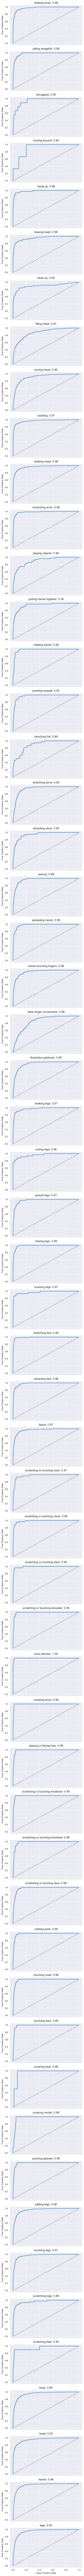

In [36]:
# Plot ROC curves and display additional information
# fig, axes = plt.subplots(nrows=1, ncols=len(roc_metrics), figsize=(15, 5))
num_lables = len(roc_metrics)
fig, axes = plt.subplots(nrows=num_lables, ncols=1, figsize=(5, 150))

for i, (label, metrics) in enumerate(roc_metrics.items()):
    tpr = metrics['tpr']
    fpr = metrics['fpr']
    auc = metrics['auc']
    auc_value = metrics['auc']

    # Plot ROC curve
    axes[i].plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
    axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

    # Add title, AUC value, and additional information

    # axes[i].set_title(label)
    
    # axes[i].set_title(f'{ID2LABELS[int(label)+1]}: {auc_value:.2f}')
    axes[i].set_title(f'{label}: {auc_value:.2f}')
    # axes[i].set_title(f'{label}: {auc_value:.2f}')
    # axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    # if i==0:
    if i == num_lables-1:
        # axes[i].set_ylabel('True Positive Rate')
        axes[i].set_xlabel('False Positive Rate')
    # axes[i].legend(loc='lower right')
    else:
        # axes[i].set_yticklabels([])
        axes[i].set_xticklabels([])

    # Add text with additional information
    # axes[i].text(0.5, 0.1, f'True: {true_counts[label]}\nCorrect: {correct_counts[label]}\nMisclassified: {misclassified_counts[label]}',
    #              ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

    

In [37]:
# # Gap analysis on lower predictions
# detection_th = 0.7
# sum_variables = ['micro avg', 'weighted avg','samples avg','macro avg']
# bad_features = df_report.loc[df_report['f1-score']<detection_th]
# bad_features_list = [a for a in bad_features.index if a not in sum_variables]
# print(f'bad features: {bad_features_list}')
# 
# good_features = df_report.loc[df_report['f1-score']>=detection_th]
# good_features_list = [a for a in good_features.index if a not in sum_variables]
# print(f'good features: {good_features_list}')

In [38]:
# logits.columns

In [39]:
# df_optimal_preds

In [40]:
# selected_feature = 'shaking body'
# TH = 0.4
# temp_df = df_optimal_preds[[a for a in df_optimal_preds.columns if selected_feature in a]].copy()
# temp_df = logits[[f'logit-{selected_feature}']].copy()
# temp_df = temp_df.rename(columns={'logit-'+selected_feature: selected_feature})
# temp_df['correct'] = (temp_df[selected_feature]>TH) == gt[f'gt-{selected_feature}']
# # temp_df['correct'] = (temp_df[selected_feature]) == gt[f'gt-{selected_feature}']
# FN = temp_df.loc[(~temp_df['correct'])&(gt[f'gt-{selected_feature}']==1)]
# FP = temp_df.loc[(~temp_df['correct'])&(gt[f'gt-{selected_feature}']==0)]
# TP = temp_df.loc[(temp_df['correct'])&(gt[f'gt-{selected_feature}']==1)]

In [41]:
# temp_df.index

In [42]:
# df_row

In [43]:
"""
i have a dataframe called df_data
if has the following columns: filenames (unique for each sample), a set of columns that start with the name "logit-" these are the logits that the model predicted for each class, a number between 1 to 0
a set of columns that start with "pred-" these are the model predictions, they can be 1 or 0
and a self of columns that start with "gt-" these are ground truth labels.

when you need to extract the class name from a columns, just run a.replace('gt-','').replace('pred-','').replace('logit-','') to remove those parts

add the following columns:
top_5_pred:
for each row, extract the logit columns,
sort the logits according to the logit values
create a dictionary with class name : logit of the top 5 classes

the second columns to add is :
predicted_classes:
for each row extract the pred columns,
create a list of class names that have pred == 1

the last columns to add is:
gt_classes:
for each row extract the gtcolumns,
create a list of class names that have gt== 1
"""

'\ni have a dataframe called df_data\nif has the following columns: filenames (unique for each sample), a set of columns that start with the name "logit-" these are the logits that the model predicted for each class, a number between 1 to 0\na set of columns that start with "pred-" these are the model predictions, they can be 1 or 0\nand a self of columns that start with "gt-" these are ground truth labels.\n\nwhen you need to extract the class name from a columns, just run a.replace(\'gt-\',\'\').replace(\'pred-\',\'\').replace(\'logit-\',\'\') to remove those parts\n\nadd the following columns:\ntop_5_pred:\nfor each row, extract the logit columns,\nsort the logits according to the logit values\ncreate a dictionary with class name : logit of the top 5 classes\n\nthe second columns to add is :\npredicted_classes:\nfor each row extract the pred columns,\ncreate a list of class names that have pred == 1\n\nthe last columns to add is:\ngt_classes:\nfor each row extract the gtcolumns,\ncr

In [44]:
df_data = df.reset_index().copy()

# Function to extract class name from column name
def extract_class_name(col_name):
    return col_name.replace('gt-', '').replace('pred-', '').replace('logit-', '')

# Function to get top 5 predictions
def get_top_5_pred(row):
    logits = {extract_class_name(col): row[col] for col in df_data.columns if col.startswith('logit-')}
    sorted_logits = sorted(logits.items(), key=lambda item: item[1], reverse=True)[:5]
    return sorted_logits

# Function to get predicted classes
def get_predicted_classes(row):
    return [extract_class_name(col) for col in df_data.columns if col.startswith('pred-') and row[col] == 1]

# Function to get ground truth classes
def get_gt_classes(row):
    return [extract_class_name(col) for col in df_data.columns if col.startswith('gt-') and row[col] == 1]

# Apply functions to dataframe
df_data['top_5_pred'] = df_data.apply(get_top_5_pred, axis=1)
df_data['predicted_classes'] = df_data.apply(get_predicted_classes, axis=1)
df_data['gt_classes'] = df_data.apply(get_gt_classes, axis=1)

# Display the resulting dataframe
df_data[['filenames','top_5_pred','predicted_classes','gt_classes']]

,filenames,top_5_pred,predicted_classes,gt_classes
0,0003_01_0005.mp4,"[(head, 0.93408203125), (turning head, 0.68261...","[turning head, shaking head, head]","[turning head, head]"
1,0003_01_0006.mp4,"[(head, 0.9248046875), (nodding, 0.77978515625...","[nodding, head]","[turning head, head]"
2,0003_01_0008.mp4,"[(nodding, 0.9521484375), (head, 0.93212890625...","[nodding, head]","[shaking head, head]"
3,0003_01_0015.mp4,"[(head, 0.65380859375), (turning head, 0.49096...","[turning head, shaking head, head]","[turning head, head]"
4,0003_01_0021.mp4,"[(nodding, 0.97314453125), (head, 0.955078125)...","[nodding, head]","[nodding, head]"
...,...,...,...,...
5581,0193_05_0006.mp4,"[(hands, 0.82080078125), (scratching or touchi...","[playing or tidying hair, scratching or touchi...","[playing or tidying hair, head, hands]"
5582,0193_05_0011.mp4,"[(hands, 0.67578125), (scratching or touching ...","[arms akimbo, scratching or touching hindbrain...","[scratching or touching hindbrain, head, hands]"
5583,0193_05_0013.mp4,"[(hands, 0.92529296875), (head, 0.6640625), (o...","[other finger movements, scratching or touchin...","[pushing glasses, head, hands]"
5584,0193_05_0016.mp4,"[(hands, 0.9111328125), (head, 0.68115234375),...","[scratching or touching face, rubbing eyes, to...","[pushing glasses, head, hands]"


In [45]:
# selected_feature = 'shaking body'
# TH = 0.5
# 
# # Create temp_df
# # temp_df = df_optimal_preds[[a for a in df_optimal_preds.columns if selected_feature in a]].copy()
# temp_df = logits[[f'logit-{selected_feature}']].copy()
# temp_df = temp_df.rename(columns={'logit-'+selected_feature: selected_feature})
# temp_df['correct'] = (temp_df[selected_feature]>TH) == gt[f'gt-{selected_feature}']
# 
# 
# # Add the "predicted" column
# predicted = []
# true_labels = []
# # 
# df_data = df_optimal_preds.copy()
# df_data = df_data.reset_index()
# # Iterate over the rows of temp_df
# for index, row in temp_df.reset_index().iterrows():
#     filename = row['filenames']  # Assuming there's a "filenames" column in temp_df
#     df_row = df_data.loc[df_data['filenames']==filename]
# 
#     # Extract logits columns and filter by threshold
#     logits_cols = {col: df_row[col].values[0] for col in df_row.columns if col.startswith('logit-')}
#     filtered_logits = {col: val for col, val in logits_cols.items() if val >= TH}
#     
# 
#     # Create a dictionary with class names as keys and logits as values
#     class_logits = {col.replace('logit-', ''): val for col, val in filtered_logits.items()}
# 
#     # Sort the dictionary by logits in descending order
#     sorted_class_logits = sorted(class_logits.items(), key=lambda item: item[1], reverse=True)
# 
#     # Add the sorted list of dictionaries to the "predicted" column
#     predicted.append(sorted_class_logits)
# 
# # Assign the predicted list to the new "predicted" column in temp_df
# temp_df['predicted'] = predicted
# 
# # Extract FN, FP, TP
# FN = temp_df.loc[(~temp_df['correct']) & (gt[f'gt-{selected_feature}'] == 1)]
# FP = temp_df.loc[(~temp_df['correct']) & (gt[f'gt-{selected_feature}'] == 0)]
# TP = temp_df.loc[(temp_df['correct']) & (gt[f'gt-{selected_feature}'] == 1)]

In [59]:
import utils

from importlib import reload
reload(utils)
plot_confidence_heatmap = utils.plot_confidence_heatmap

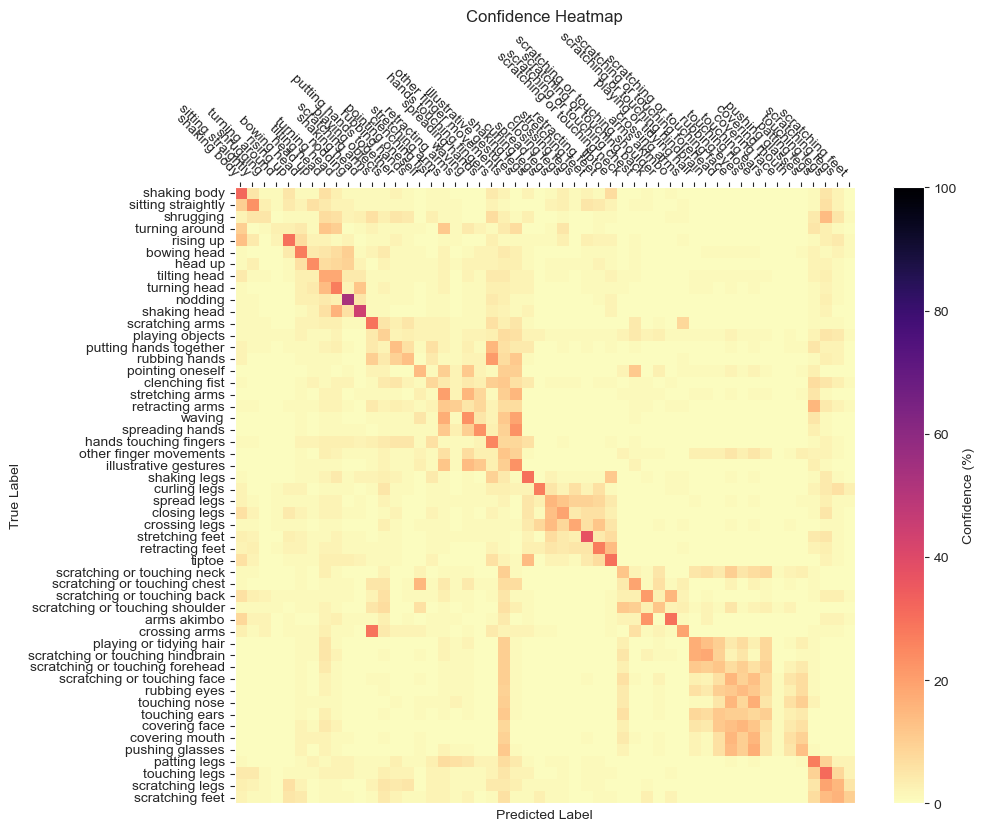

In [47]:
y_true_df = df[gt_columns].values
# y_true_df = y_true_df.rename(columns={a:ID2LABELS[1+int(a.split('-')[-1])] for a in y_true_df.columns})
y_pred_df = df[logit_columns].values
# y_pred_df = y_pred_df.rename(columns={a:ID2LABELS[1+int(a.split('-')[-1])] for a in y_pred_df.columns})
remove_features = ['head','hands','body','legs']
plot_confidence_heatmap(y_true_df, y_pred_df, feature_names, remove_features, annot=False)

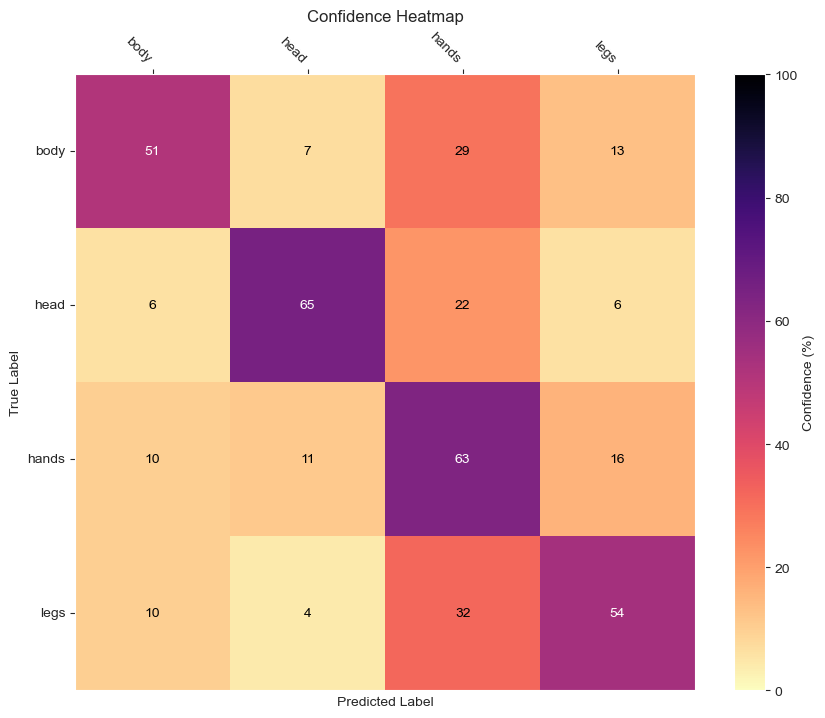

In [48]:
y_true_df = df[gt_columns].values
# y_true_df = y_true_df.rename(columns={a:ID2LABELS[1+int(a.split('-')[-1])] for a in y_true_df.columns})
y_pred_df = df[logit_columns].values
# y_pred_df = y_pred_df.rename(columns={a:ID2LABELS[1+int(a.split('-')[-1])] for a in y_pred_df.columns})
remove_features = list(set(feature_names) - set(['head','hands','body','legs']))
plot_confidence_heatmap(y_true_df, y_pred_df, feature_names, remove_features, annot=True)

In [49]:
df.columns

Index(['logit-shaking body', 'logit-sitting straightly', 'logit-shrugging',
       'logit-turning around', 'logit-rising up', 'logit-bowing head',
       'logit-head up', 'logit-tilting head', 'logit-turning head',
       'logit-nodding',
       ...
       'gt-covering mouth', 'gt-pushing glasses', 'gt-patting legs',
       'gt-touching legs', 'gt-scratching legs', 'gt-scratching feet',
       'gt-body', 'gt-head', 'gt-hands', 'gt-legs'],
      dtype='object', length=168)

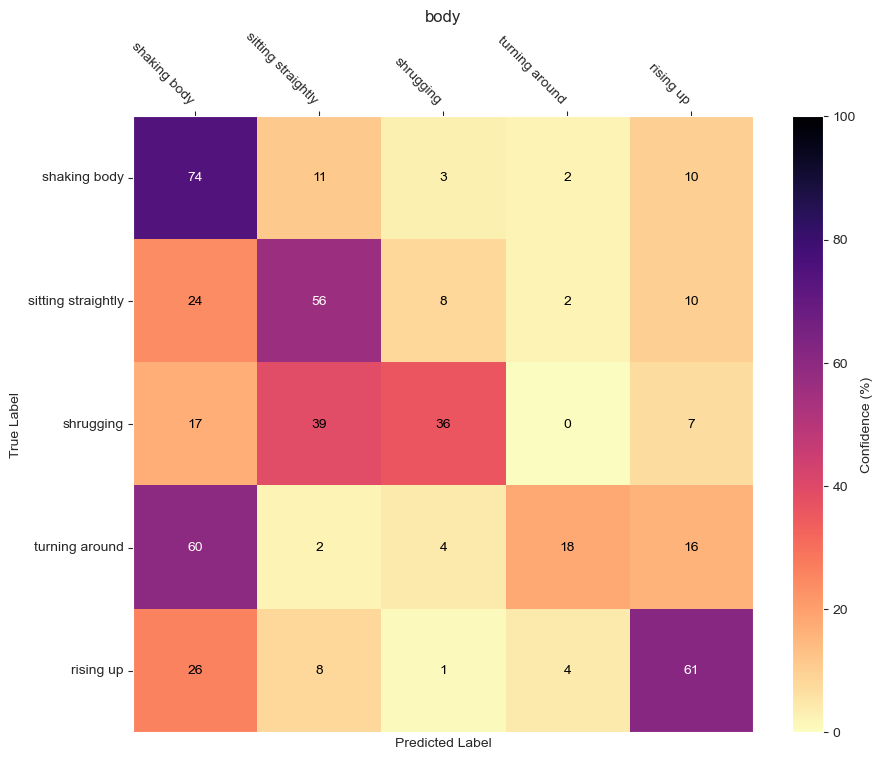

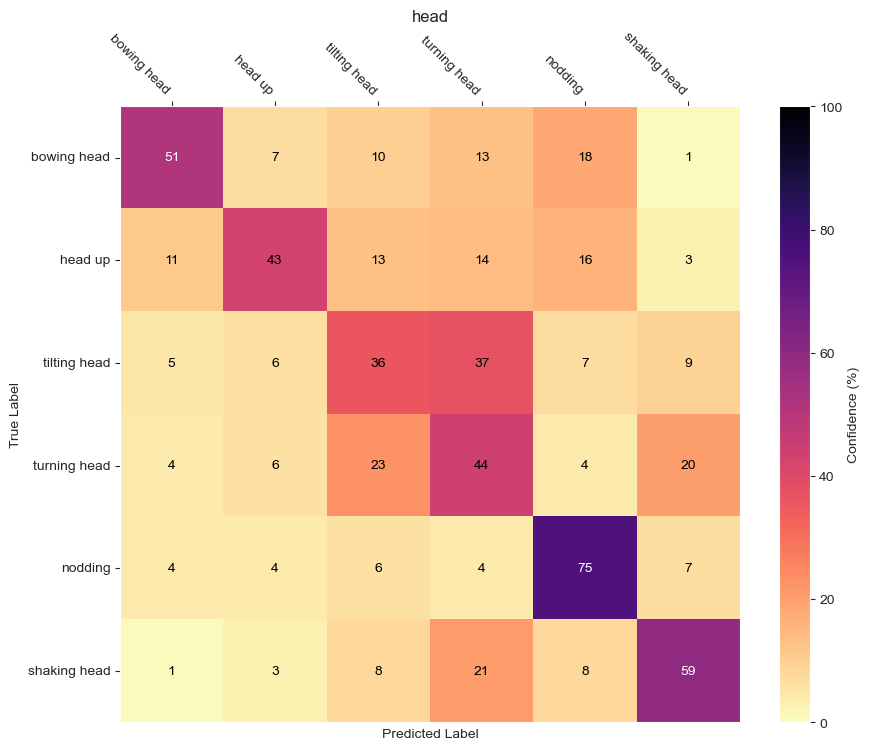

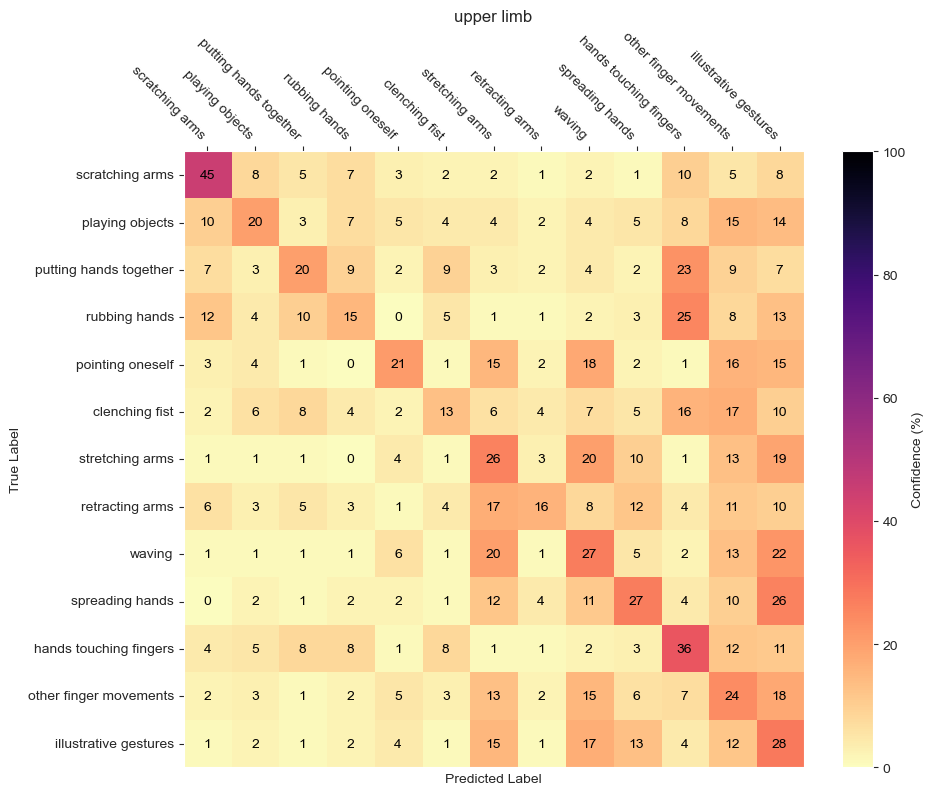

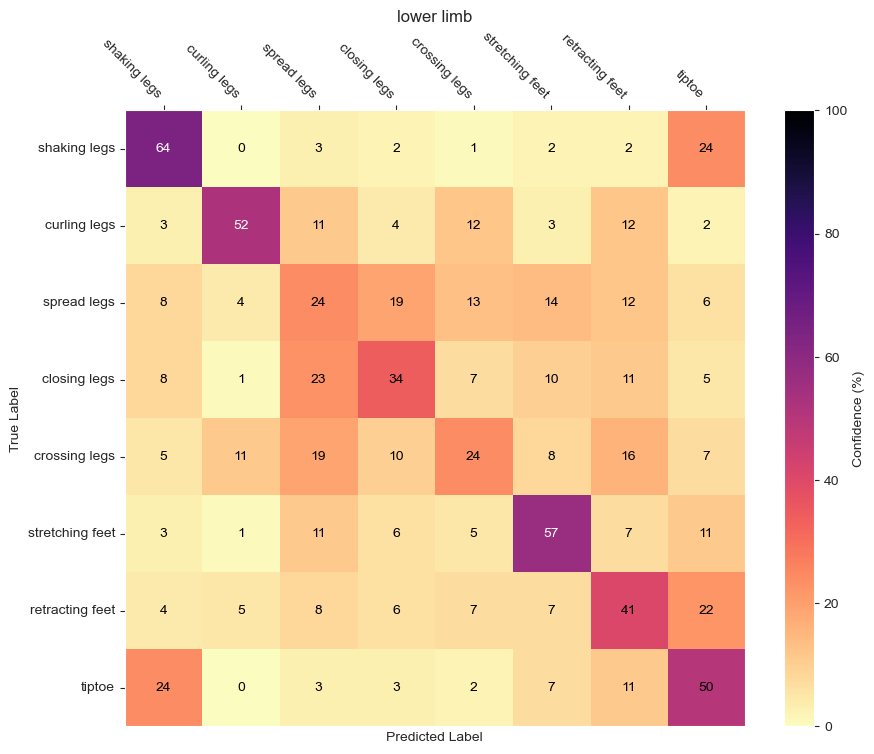

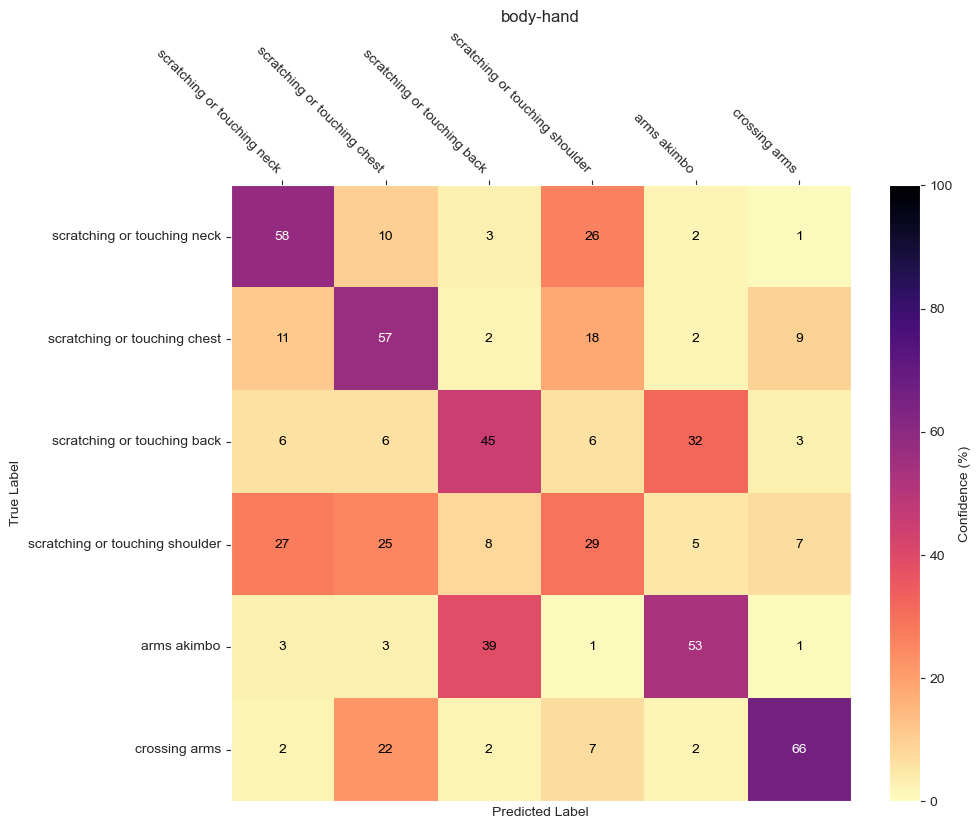

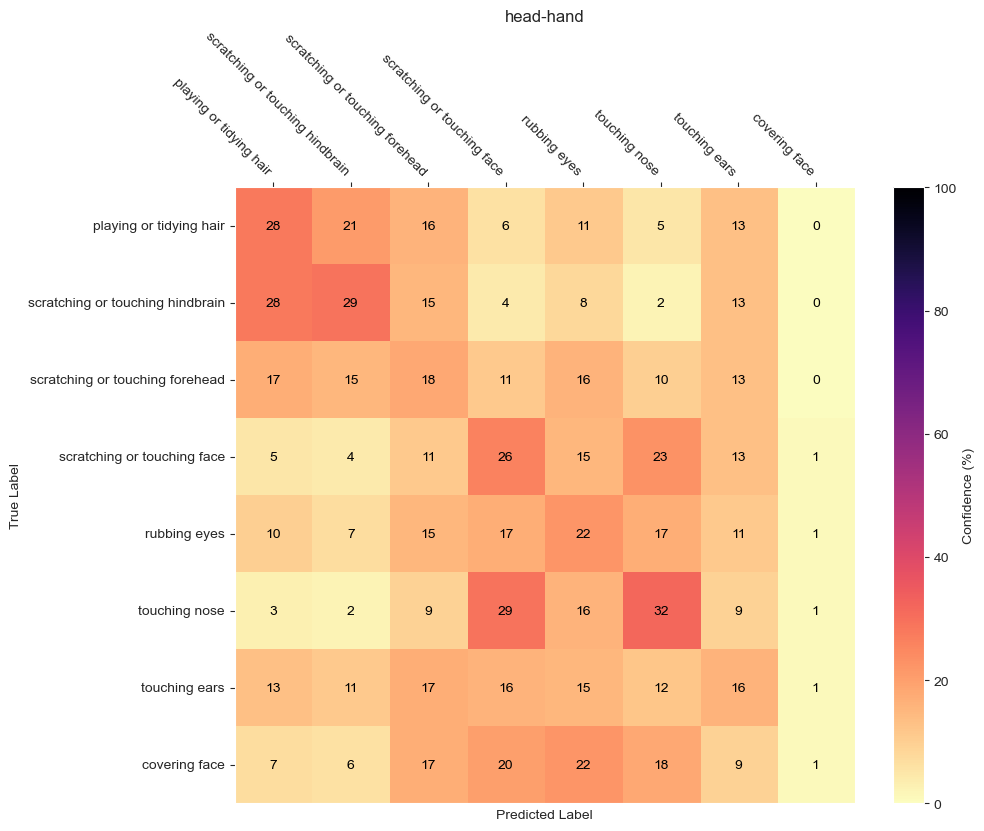

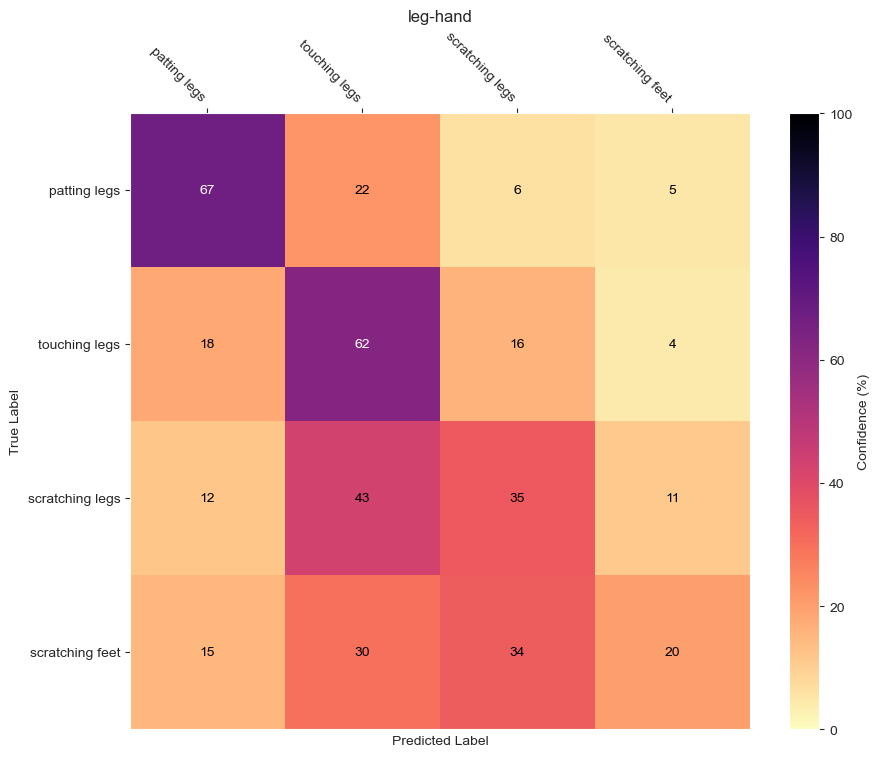

In [60]:
# fine2coarse, COARSE_LABEL, COARSE2FINE

INV_COARSE_LABEL = {v:k for k,v in COARSE_LABEL.items()}
# INV_ID2LABELS = {v:k for k,v in ID2LABELS.items()}

def coarse2fine(body_part):
    body_part_num = INV_COARSE_LABEL[body_part]
    fine_labels_num = COARSE2FINE[body_part_num]
    fine_labels = [ID2LABELS[a] for a in fine_labels_num]
    return fine_labels

coarse_labels = COARSE_LABEL.values()
for body_part in coarse_labels:
    fine_labels = coarse2fine(body_part=body_part)
    gt_columns_group = [a for a in gt_columns if a.split('-')[-1] in fine_labels]
    logit_columns_group = [a for a in logit_columns if a.split('-')[-1] in fine_labels]
    y_true_df = df[gt_columns_group].values
    y_pred_df = df[logit_columns_group].values
    plot_confidence_heatmap(y_true_df, y_pred_df, feature_names=fine_labels, annot=True, plot_tile=body_part)

In [56]:
[a.split('-')[-1] for a in gt_columns]

['shaking body',
 'sitting straightly',
 'shrugging',
 'turning around',
 'rising up',
 'bowing head',
 'head up',
 'tilting head',
 'turning head',
 'nodding',
 'shaking head',
 'scratching arms',
 'playing objects',
 'putting hands together',
 'rubbing hands',
 'pointing oneself',
 'clenching fist',
 'stretching arms',
 'retracting arms',
 'waving',
 'spreading hands',
 'hands touching fingers',
 'other finger movements',
 'illustrative gestures',
 'shaking legs',
 'curling legs',
 'spread legs',
 'closing legs',
 'crossing legs',
 'stretching feet',
 'retracting feet',
 'tiptoe',
 'scratching or touching neck',
 'scratching or touching chest',
 'scratching or touching back',
 'scratching or touching shoulder',
 'arms akimbo',
 'crossing arms',
 'playing or tidying hair',
 'scratching or touching hindbrain',
 'scratching or touching forehead',
 'scratching or touching face',
 'rubbing eyes',
 'touching nose',
 'touching ears',
 'covering face',
 'covering mouth',
 'pushing glasses',
